# Meko računanje 
Pripremio: Dimitrije Milenković

Mentor: prof. dr. Mirko Vujošević

# Demo projekat: Klasifikacija teksta

U ovom demo projektu biće prikazana izgradnja modela koji klasifikuje recenzije filmova na popularnom sajtu IMDB kao pozitivne ili negativne.

Za demo je korišćen dataset ugrađen u Tensorflow biblioteku. Čitav proces biće ukratko objašnjen. 

**Važno:** Ova radna sveska prvenstveno demonstrira korišćenje TensorFlowa za izgradnju modela dubinskog učenja. S toga, akcenat je na kodu i rezultatima. Sav tekst i slike služe kao beleške, s toga nisu formalno i pravilno formatirane, te su moguće greške. Isključivo ih posmatrati kao komentare uz kod. 

Na poćetku inicijalizujemo okruženje i učitavamo potrebne pakete.

## Inicijalizacija okruženja

In [0]:
import sys
!{sys.executable} -m pip install -q tensorflow==2.0.0-beta1

In [27]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
print("Version: ", tf.__version__)

Version:  2.0.0-beta1


In [0]:
import numpy as np
import matplotlib.pyplot as plt


In [29]:
import tensorflow_datasets as tfds
import tensorflow_hub as hub

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0-beta1
Eager mode:  True
Hub version:  0.4.0
GPU is NOT AVAILABLE


## Učitavanje podataka

Trening set smo podelili na 60-40 %, kako dobijamo 15000 obzervacija za trening, 10000 za validaciju i  25000 za testiranje.

In [0]:
train_validation_split = tfds.Split.TRAIN.subsplit([6, 4])

(train_data, validation_data), test_data = tfds.load(
    name="imdb_reviews", 
    split=(train_validation_split, tfds.Split.TEST),
    as_supervised=True)

## Uvid u podatke

Svaka obzervacija sadrži recenziju filma u vidu teksta i pridruženu labelu - 0 ili 1, gde 0 označava negativnu recenziju, a 1 pozitivnu.

U nastavku su prikazane prve 10 obzervacije i njihove labele.

In [31]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

<tf.Tensor: id=101731, shape=(10,), dtype=string, numpy=
array([b"As a lifelong fan of Dickens, I have invariably been disappointed by adaptations of his novels.<br /><br />Although his works presented an extremely accurate re-telling of human life at every level in Victorian Britain, throughout them all was a pervasive thread of humour that could be both playful or sarcastic as the narrative dictated. In a way, he was a literary caricaturist and cartoonist. He could be serious and hilarious in the same sentence. He pricked pride, lampooned arrogance, celebrated modesty, and empathised with loneliness and poverty. It may be a clich\xc3\xa9, but he was a people's writer.<br /><br />And it is the comedy that is so often missing from his interpretations. At the time of writing, Oliver Twist is being dramatised in serial form on BBC television. All of the misery and cruelty is their, but non of the humour, irony, and savage lampoonery. The result is just a dark, dismal experience: the stor

In [32]:
train_labels_batch

<tf.Tensor: id=101732, shape=(10,), dtype=int64, numpy=array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0])>

## Izgradnja modela

Neuronske mreže izgrađene su nadovezivanjem više slojeva. Zato, možemo reći da izgradnja zahteva tri arhitekturalna pitanja:

- Kako predstaviti tekst?
- Koliko slojeva treba da ima model?
- Koliko neurona treba da imaju skriveni slojevi?

Jedan od načina predstaviti tekst je u obliku ugrađenih vektora. Postoji dosta dostupnih pretreniranih *embedding* modela za engleski jezik. Mi ćemo jedan takav koristiti kao prvi sloj naše neuronske mreže, kako bi dobili reprezentaciju teksta sa kojom možemo dalje da radimo. Ugrađeni modeli dostupni su preko Tensorflow Huba, a o modelu koji će se koristiti u ovom primeru možete više pročitatu u [ovom radu](https://arxiv.org/abs/1602.02215.).

Napominjemo da će kasnije biti prikazan pristup bez korišćenja pretreniranog modela.

In [33]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: id=101913, shape=(3, 20), dtype=float32, numpy=
array([[ 3.9819887 , -4.4838037 ,  5.177359  , -2.3643482 , -3.2938678 ,
        -3.5364532 , -2.4786978 ,  2.5525482 ,  6.688532  , -2.3076782 ,
        -1.9807833 ,  1.1315885 , -3.0339816 , -0.7604128 , -5.743445  ,
         3.4242578 ,  4.790099  , -4.03061   , -5.992149  , -1.7297493 ],
       [ 3.4232912 , -4.230874  ,  4.1488533 , -0.29553518, -6.802391  ,
        -2.5163853 , -4.4002395 ,  1.905792  ,  4.7512794 , -0.40538004,
        -4.3401685 ,  1.0361497 ,  0.9744097 ,  0.71507156, -6.2657013 ,
         0.16533905,  4.560262  , -1.3106939 , -3.1121316 , -2.1338716 ],
       [ 3.8508697 , -5.003031  ,  4.8700504 , -0.04324996, -5.893603  ,
        -5.2983093 , -4.004676  ,  4.1236343 ,  6.267754  ,  0.11632943,
        -3.5934832 ,  0.8023905 ,  0.56146765,  0.9192484 , -7.3066816 ,
         2.8202746 ,  6.2000837 , -3.5709393 , -4.564525  , -2.305622  ]],
      dtype=float32)>

Nakon što smo napravili prvi sloj, dodaćemo ga u model i kreirati ostale slojeve. Nivoi će se sekvencijalno nadovezivati kako bi izgradili klasifikator. Na drugom sloju smo izabrali da imamo potpuno povezan nivo koji na outputu daje 16 neurona, a koristi RELU aktivaconu funkciju. Poslednji nivo koristi sigmoidnu funkciju da transformiše izlaz u jednu jedinicu koja će označavati verovatnoću da je recenzija pozitivna(1).

U nastavku su prikazane aktivacione funkcije koje su korišćene.
![relu-sigmoid](https://cdn-images-1.medium.com/max/1600/1*XxxiA0jJvPrHEJHD4z893g.png)

In [34]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense_17 (Dense)             (None, 16)                336       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


### Loss funkcija i optimizacija

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Treniranje modela

Treniramo model u 20 epoha, tokom treniranja pratimo gubitak i t;anost modela na 10000 primeraka iz validacionog seta.

In [36]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=20,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 7s 241ms/step - loss: 1.0224 - accuracy: 0.5847 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
30/30 [==============================] - 6s 210ms/step - loss: 0.7253 - accuracy: 0.6326 - val_loss: 0.6828 - val_accuracy: 0.6454
Epoch 3/20
30/30 [==============================] - 6s 215ms/step - loss: 0.6376 - accuracy: 0.6584 - val_loss: 0.6123 - val_accuracy: 0.6760
Epoch 4/20
30/30 [==============================] - 6s 209ms/step - loss: 0.5755 - accuracy: 0.6998 - val_loss: 0.5669 - val_accuracy: 0.7079
Epoch 5/20
30/30 [==============================] - 6s 211ms/step - loss: 0.5327 - accuracy: 0.7370 - val_loss: 0.5339 - val_accuracy: 0.7339
Epoch 6/20
30/30 [==============================] - 6s 211ms/step - loss: 0.4976 - accuracy: 0.7653 - val_loss: 0.5051 - val_accuracy: 0.7597
Epoch 7/20
30/30 [==============================] - 6s 211ms/step - loss: 0.4647 - accuracy: 0.7905 - val_loss: 0.4778 - val_accuracy: 0.780

### Evaluacija modela

Vidimo da smo u poslednjoj epohi dobili tačnost od 0.9393 na valdiacionom setu. Međutim, s obzirom da smo taj set koristili tokom treniranja, taj broj nam ne znači puno. Zato ćemo evaluirati naš model na test setu koji model tokom treniranja uopšte nije video. Na njemu dobijamo tačnost od 0.861 što je jako dobro.

In [37]:
results = model.evaluate(test_data.batch(512), verbose=0)
for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

loss: 0.320
accuracy: 0.864


## Multi-hot enkodiranje teksta

Jedan od pristupa enkodiranja teksta kako bi on bio pogodan za korišćenje u modelima jeste i mutli-hot. Ovaj pristup podrazumeva da kreiranje multidimenzionalnog vektora koji će sadržati sve reči koje se pojavljuju, a za svaku obzervaciju svakoj reči biće dodeljena vrednost 1 ako se ta reč pojavljuje, a 0 ako se ne pojavljuje. 

In [0]:
NUM_WORDS = 10000

(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.imdb.load_data(num_words=NUM_WORDS)

def multi_hot_sequences(sequences, dimension):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # set specific indices of results[i] to 1s
    return results


train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

U nastavku je prikazan multi'hot vektor za prvu obzervaciju.

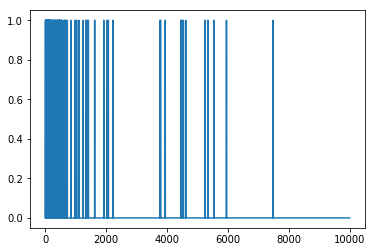

In [39]:
plt.plot(train_data[0])

## Demonstriranje pretreniranja i podtreniranja

Kada pravimo složenije modele, oni postoji sposobniji da se prilagode bilo kakvim podacima i nauče pravilnosti iz njih. Međutim, to nas "gura u zamku overfittinga", slučaja da se naša mreža toliko nauči na trening setu, tako da nauči izuzetke i onda bude lošija u predviđanju nad novim podacima koje nije videla.

### Kreiranje osnovnog modela

In [40]:
baseline_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    tf.keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

baseline_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_20 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [41]:
baseline_history = baseline_model.fit(train_data,
                                      train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_data, test_labels),
                                      verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 4s - loss: 0.4899 - accuracy: 0.8036 - binary_crossentropy: 0.4899 - val_loss: 0.3427 - val_accuracy: 0.8748 - val_binary_crossentropy: 0.3427
Epoch 2/20
25000/25000 - 3s - loss: 0.2524 - accuracy: 0.9130 - binary_crossentropy: 0.2524 - val_loss: 0.2857 - val_accuracy: 0.8890 - val_binary_crossentropy: 0.2857
Epoch 3/20
25000/25000 - 3s - loss: 0.1845 - accuracy: 0.9365 - binary_crossentropy: 0.1845 - val_loss: 0.2909 - val_accuracy: 0.8832 - val_binary_crossentropy: 0.2909
Epoch 4/20
25000/25000 - 3s - loss: 0.1504 - accuracy: 0.9494 - binary_crossentropy: 0.1504 - val_loss: 0.3184 - val_accuracy: 0.8757 - val_binary_crossentropy: 0.3184
Epoch 5/20
25000/25000 - 3s - loss: 0.1250 - accuracy: 0.9597 - binary_crossentropy: 0.1250 - val_loss: 0.3298 - val_accuracy: 0.8750 - val_binary_crossentropy: 0.3298
Epoch 6/20
25000/25000 - 3s - loss: 0.1049 - accuracy: 0.9679 - binary_crossentropy: 0.1049 - val_loss: 0.3556

Vidimo da je ova mreža došla do tačnosti od 100% na validacionom setu. To može da bude alarm da proverimo da li je ona slučajno pretrenirana. Kasnije ćemo proveriti koliko je ona tačna nad novim podacima. Sada probajmo da napravimo manji model.

### Kreiranje manjeg modela

In [42]:
smaller_model = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu', input_shape=(NUM_WORDS,)),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

smaller_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', 'binary_crossentropy'])

smaller_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 4)                 40004     
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [43]:
smaller_history = smaller_model.fit(train_data,
                                    train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data, test_labels),
                                    verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 4s - loss: 0.6164 - accuracy: 0.6441 - binary_crossentropy: 0.6164 - val_loss: 0.5581 - val_accuracy: 0.7958 - val_binary_crossentropy: 0.5581
Epoch 2/20
25000/25000 - 3s - loss: 0.5042 - accuracy: 0.8306 - binary_crossentropy: 0.5042 - val_loss: 0.4955 - val_accuracy: 0.8466 - val_binary_crossentropy: 0.4955
Epoch 3/20
25000/25000 - 3s - loss: 0.4428 - accuracy: 0.8857 - binary_crossentropy: 0.4428 - val_loss: 0.4584 - val_accuracy: 0.8702 - val_binary_crossentropy: 0.4584
Epoch 4/20
25000/25000 - 3s - loss: 0.3962 - accuracy: 0.9121 - binary_crossentropy: 0.3962 - val_loss: 0.4305 - val_accuracy: 0.8770 - val_binary_crossentropy: 0.4305
Epoch 5/20
25000/25000 - 3s - loss: 0.3546 - accuracy: 0.9302 - binary_crossentropy: 0.3546 - val_loss: 0.4073 - val_accuracy: 0.8787 - val_binary_crossentropy: 0.4073
Epoch 6/20
25000/25000 - 3s - loss: 0.3138 - accuracy: 0.9421 - binary_crossentropy: 0.3138 - val_loss: 0.3840

### Kreiranje složenog (velikog) modela

In [44]:
bigger_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(NUM_WORDS,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

bigger_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy','binary_crossentropy'])

bigger_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 512)               5120512   
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


In [45]:
bigger_history = bigger_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 17s - loss: 0.3448 - accuracy: 0.8517 - binary_crossentropy: 0.3448 - val_loss: 0.3029 - val_accuracy: 0.8753 - val_binary_crossentropy: 0.3029
Epoch 2/20
25000/25000 - 16s - loss: 0.1469 - accuracy: 0.9463 - binary_crossentropy: 0.1469 - val_loss: 0.3360 - val_accuracy: 0.8709 - val_binary_crossentropy: 0.3360
Epoch 3/20
25000/25000 - 16s - loss: 0.0521 - accuracy: 0.9850 - binary_crossentropy: 0.0521 - val_loss: 0.4522 - val_accuracy: 0.8679 - val_binary_crossentropy: 0.4522
Epoch 4/20
25000/25000 - 16s - loss: 0.0082 - accuracy: 0.9985 - binary_crossentropy: 0.0082 - val_loss: 0.6128 - val_accuracy: 0.8646 - val_binary_crossentropy: 0.6128
Epoch 5/20
25000/25000 - 16s - loss: 0.0012 - accuracy: 1.0000 - binary_crossentropy: 0.0012 - val_loss: 0.6778 - val_accuracy: 0.8695 - val_binary_crossentropy: 0.6778
Epoch 6/20
25000/25000 - 16s - loss: 2.4113e-04 - accuracy: 1.0000 - binary_crossentropy: 2.4113e-04 - va

## Evaluacija i poređenje modela
 
 
Ispod je dat uporedni prikaz tačnosti na trening i validacionim setovima za sva tri modela.

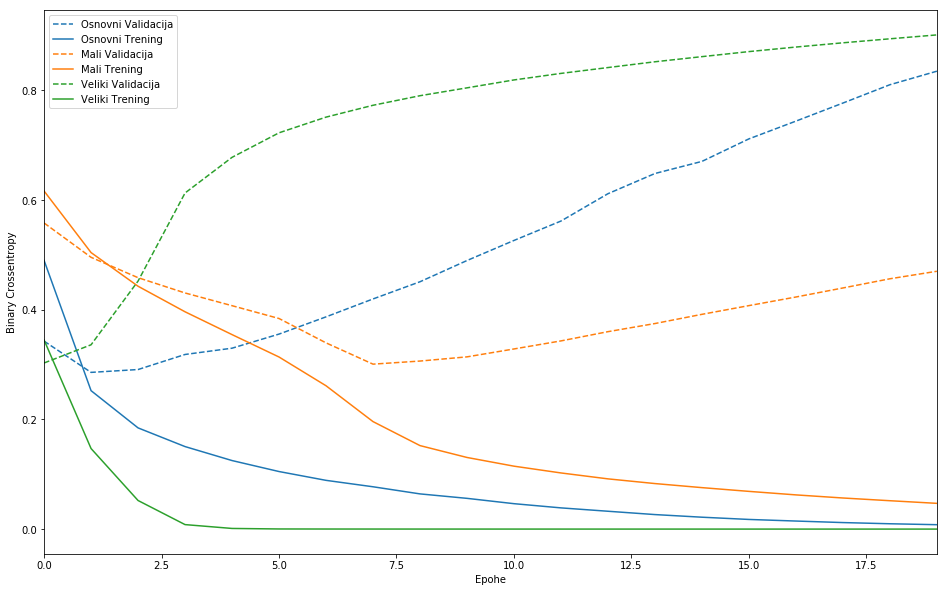

In [46]:
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Validacija')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Trening')

  plt.xlabel('Epohe')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('Osnovni', baseline_history),
              ('Mali', smaller_history),
              ('Veliki', bigger_history)])

Primetimo da velike mreže počinju da overfittuju odmah na početku, posle jedne epohe. Što veći kapacitet mreža ima, ona će brže naučiti iz trening podataka, što rezultuje u malom trening gubitku, ali je zato osetljivija na overfitting, što rezultuje većom razlikom u gubitku na trening i validacionom setu.

## Strategije za prevenciju pretreniranja

### Regularizacija

Jedan od najčešće korišćenih metoda za prevenciju pretreniranja je regularizacija. Regularizacija funkcioniše tako što ograničava težine koeficijanata u funkciji na male vrednosti.

Popularne su sledeće:
- L1 Regularizacija
- L2 Regularizacija

![regularizacija](https://cdn-images-1.medium.com/max/2400/1*zMLv7EHYtjfr94JOBzjqTA.png)



In [47]:
l2_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.001),
                       activation='relu', input_shape=(NUM_WORDS,)),
    tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.001),
                       activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

l2_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

l2_model_history = l2_model.fit(train_data, train_labels,
                                epochs=20,
                                batch_size=512,
                                validation_data=(test_data, test_labels),
                                verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 4s - loss: 0.5082 - accuracy: 0.8050 - binary_crossentropy: 0.4695 - val_loss: 0.3629 - val_accuracy: 0.8795 - val_binary_crossentropy: 0.3230
Epoch 2/20
25000/25000 - 3s - loss: 0.2885 - accuracy: 0.9117 - binary_crossentropy: 0.2446 - val_loss: 0.3317 - val_accuracy: 0.8869 - val_binary_crossentropy: 0.2850
Epoch 3/20
25000/25000 - 3s - loss: 0.2388 - accuracy: 0.9330 - binary_crossentropy: 0.1897 - val_loss: 0.3380 - val_accuracy: 0.8838 - val_binary_crossentropy: 0.2871
Epoch 4/20
25000/25000 - 3s - loss: 0.2182 - accuracy: 0.9430 - binary_crossentropy: 0.1655 - val_loss: 0.3575 - val_accuracy: 0.8781 - val_binary_crossentropy: 0.3035
Epoch 5/20
25000/25000 - 3s - loss: 0.2026 - accuracy: 0.9508 - binary_crossentropy: 0.1475 - val_loss: 0.3693 - val_accuracy: 0.8770 - val_binary_crossentropy: 0.3133
Epoch 6/20
25000/25000 - 3s - loss: 0.1913 - accuracy: 0.9558 - binary_crossentropy: 0.1343 - val_loss: 0.3831

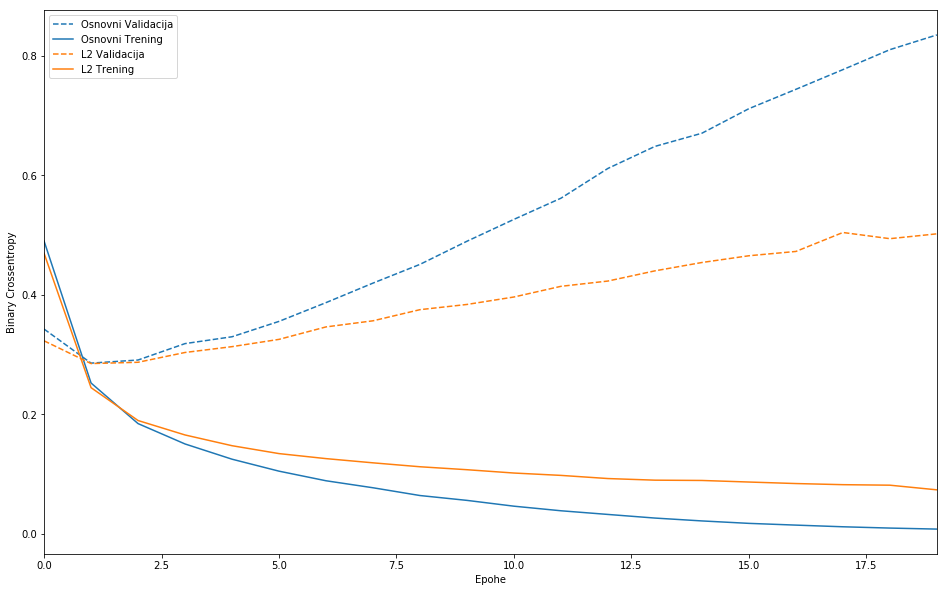

In [48]:
plot_history([('Osnovni', baseline_history),
              ('l2', l2_model_history)])

### Dropout stratregija

Druga popularna strategija za redukciju overfittinga jeste dropout. Ona podrazumeva da *manjim učenjem učimo bolje*. Funkcioniše tako što će na nivou na kom se primenjuje slučajno da "odbaci" neke od naučenih koeficijenata tokom treniranja (to jest postavi ih na nulu).

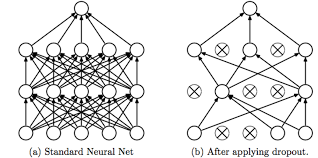

In [49]:
dpt_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

dpt_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy','binary_crossentropy'])

dpt_model_history = dpt_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 4s - loss: 0.5924 - accuracy: 0.6848 - binary_crossentropy: 0.5924 - val_loss: 0.4266 - val_accuracy: 0.8613 - val_binary_crossentropy: 0.4266
Epoch 2/20
25000/25000 - 3s - loss: 0.4158 - accuracy: 0.8301 - binary_crossentropy: 0.4158 - val_loss: 0.3112 - val_accuracy: 0.8838 - val_binary_crossentropy: 0.3112
Epoch 3/20
25000/25000 - 3s - loss: 0.3250 - accuracy: 0.8783 - binary_crossentropy: 0.3250 - val_loss: 0.2818 - val_accuracy: 0.8880 - val_binary_crossentropy: 0.2818
Epoch 4/20
25000/25000 - 3s - loss: 0.2713 - accuracy: 0.9034 - binary_crossentropy: 0.2713 - val_loss: 0.2723 - val_accuracy: 0.8888 - val_binary_crossentropy: 0.2723
Epoch 5/20
25000/25000 - 3s - loss: 0.2361 - accuracy: 0.9185 - binary_crossentropy: 0.2361 - val_loss: 0.2794 - val_accuracy: 0.8878 - val_binary_crossentropy: 0.2794
Epoch 6/20
25000/25000 - 3s - loss: 0.1966 - accuracy: 0.9341 - binary_crossentropy: 0.1966 - val_loss: 0.2991

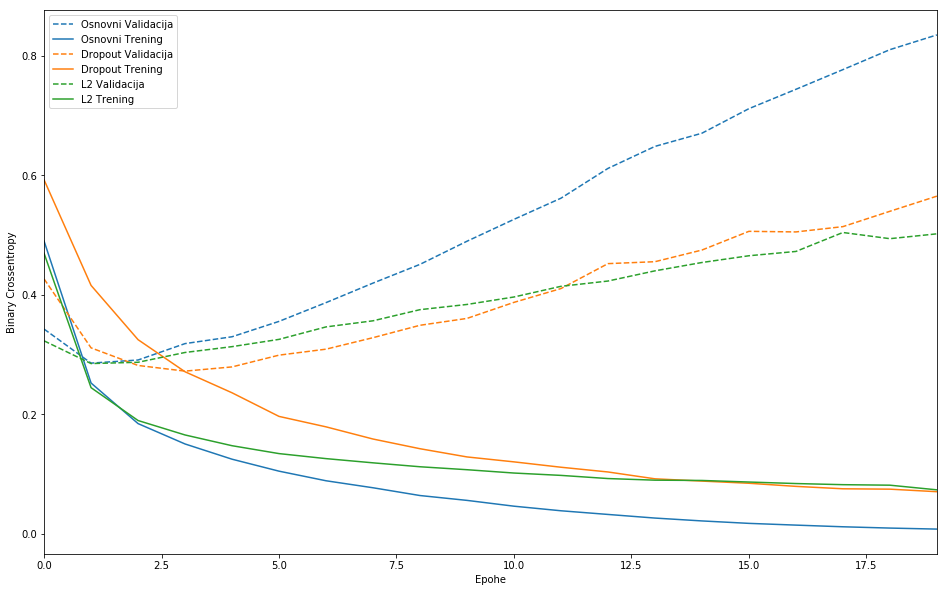

In [50]:
plot_history([('Osnovni', baseline_history),
              ('Dropout', dpt_model_history),
              ('l2', l2_model_history)])

Jasno se vidi da doddavanje Dropouta smo unapredili osnovni model.

## Literatura

- [Text Clasiffication Using TF Hub](https://www.tensorflow.org/beta/tutorials/keras/basic_text_classification_with_tfhub)

- [Tensorflow: Overfit and Underfit](https://www.tensorflow.org/beta/tutorials/keras/overfit_and_underfit)

- [Activation Functions Neural Networks](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6)

- [Swivel: Improving Embeddings by Noticing What's Missing](https://arxiv.org/abs/1602.02215.).

- [Implementing Different combination of L1 /L2 norm/regularization to Deep Neural Network (regression) with interactive code](https://towardsdatascience.com/only-numpy-implementing-different-combination-of-l1-norm-l2-norm-l1-regularization-and-14b01a9773b)